# Multi-label classification of research papers based on their abstract

## 1. Introduction

### 1.1 Task formulation

We are going to build a multi-label model that can tag research paper abstracts with several appropriate labels, eg. math, physics, finance...

In multi-label classification, classes are not mutually exclusive. Every data set sample can be assigned with multiple labels. For example, one physics research paper may contain advanced mathematical or statistical analysis, therefore should be labeled with physics, math and stat labels.

This problem is supervized text classification problem, so we are going to explore several different classifiers to see which one works best for the given scenario. 


### 1.2 Data acquisition

We used the existing arxiv scraper ([link](https://github.com/Mahdisadjadi/arxivscraper)) to scrape from [arXiv.org](https://arxiv.org/). We scraped 3 datasets, A, B and C.


| Datasets | training data time period | test data time period | training samples | test samples |
| --- | --- | --- | --- | --- |
| A | 03/2018 | 03/2018 | 9665 | 3522 |
| B | 02/2018 - 03/2018 | 01/2019 | 25089 | 19598 |
| C | 01/2018 - 06/2018 | 01/2019 | 77349 | 19598 |

Dataset A - training and test samples where drawn from the same starting dataset <br>
Dataset B - training and test samples where obtained by scraping two different, distant time periods <br>
Dataset C - training samples were collected over the longer time period (6 months), test samples were the same as in Dataset B <br>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
notebook_path = os.path.dirname(os.path.abspath("__file__"))
rel_path = "raw_data/train_data_feb_march_2018.csv"
raw_path = os.path.join(notebook_path,rel_path)

Here is the example of a raw training data. Each entry has several values 

In [4]:
df = pd.read_csv(raw_path)
df.head()

,Unnamed: 0,id,title,subcategories,abstract,doi,created,updated,authors
0,0,704.3504,smooth r\'enyi entropy of ergodic quantum info...,quant-ph cs.it math.it,we prove that the average smooth renyi entropy...,NaN,4/26/2007,NaN,"['schoenmakers', 'tjoelker', 'tuyls', 'verbits..."
1,1,803.257,unequal error protection: an information theor...,cs.it cs.dm math.co math.it,an information theoretic framework for unequal...,10.1109/tit.2009.2032819,3/18/2008,10/25/2009,"['borade', 'nakiboglu', 'zheng']"
2,2,808.0084,on the hitting times of quantum versus random ...,quant-ph cs.ds,in this paper we define new monte carlo type c...,NaN,8/1/2008,NaN,"['magniez', 'nayak', 'richter', 'santha']"
3,3,812.2709,variations on a theme by schalkwijk and kailath,cs.it math.it,schalkwijk and kailath (1966) developed a clas...,10.1109/tit.2009.2034896,12/14/2008,11/20/2009,"['gallager', 'nakiboglu']"
4,4,903.0197,rotation distance is fixed-parameter tractable,cs.ds,rotation distance between trees measures the n...,NaN,3/1/2009,NaN,"['cleary', 'john']"


## 2. Data preprocessing and exploration

Instead of working with given sub-categories, at this point, we are going to identify 7 main categories to work with:
1. computer science (cs)
2. electrical engineering and systems science (eess)
3. matemathics (math)
4. physics (physics)
5. quantitative biology (q-bio)
6. quantitative finance (q-fin)
7. statistics (stat)

Category economy (econ) was underrepresented in both data sets, and is currently excluded from the analysis.

For now, instead of working with sub-categories, we will extract 7 main categories using 'generate_main_categories' function.

Also, there was an issue with the scraper when scraping physics category. For some reason, instead of main_category.subcategory format, it only assignes sub-categories as labels, so we are addressing that problem here as well.

In [5]:
def generate_main_categories(df):
    # Extract main categories from tag strings
    def main_categories(tags):
        main_tags = [i.split(".") for i in tags if i]
        categories = [item[0] for item in main_tags]
        categories = list(set(categories))
        return categories

    # Handling of physics sub-categories'
    def physics_tags(tags):
        physics_categories = ['astro-ph', 'cond-mat', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'nlin',
                              'nucl-ex', 'nucl-th', 'physics', 'quant-ph']
        result = ['physics' if item in physics_categories else item for item in tags]
        return list(set(result))

    df['main_categories'] = df['subcategories'].apply(main_categories)
    df['main_categories'] = df['main_categories'].apply(physics_tags)
    
# split subcategories string into list of subcategories
df['subcategories'] = df['subcategories'].str.split()

generate_main_categories(df)

In [6]:
df.head()

,Unnamed: 0,id,title,subcategories,abstract,doi,created,updated,authors,main_categories
0,0,704.3504,smooth r\'enyi entropy of ergodic quantum info...,"[quant-ph, cs.it, math.it]",we prove that the average smooth renyi entropy...,NaN,4/26/2007,NaN,"['schoenmakers', 'tjoelker', 'tuyls', 'verbits...","[math, cs, physics]"
1,1,803.257,unequal error protection: an information theor...,"[cs.it, cs.dm, math.co, math.it]",an information theoretic framework for unequal...,10.1109/tit.2009.2032819,3/18/2008,10/25/2009,"['borade', 'nakiboglu', 'zheng']","[math, cs]"
2,2,808.0084,on the hitting times of quantum versus random ...,"[quant-ph, cs.ds]",in this paper we define new monte carlo type c...,NaN,8/1/2008,NaN,"['magniez', 'nayak', 'richter', 'santha']","[cs, physics]"
3,3,812.2709,variations on a theme by schalkwijk and kailath,"[cs.it, math.it]",schalkwijk and kailath (1966) developed a clas...,10.1109/tit.2009.2034896,12/14/2008,11/20/2009,"['gallager', 'nakiboglu']","[math, cs]"
4,4,903.0197,rotation distance is fixed-parameter tractable,[cs.ds],rotation distance between trees measures the n...,NaN,3/1/2009,NaN,"['cleary', 'john']",[cs]


Now let's have a look at the data set statistics. Here is how many research papers are labeled with exactly one, two or more sub-categories. We see that majority of papers have 1-4 subcategories.

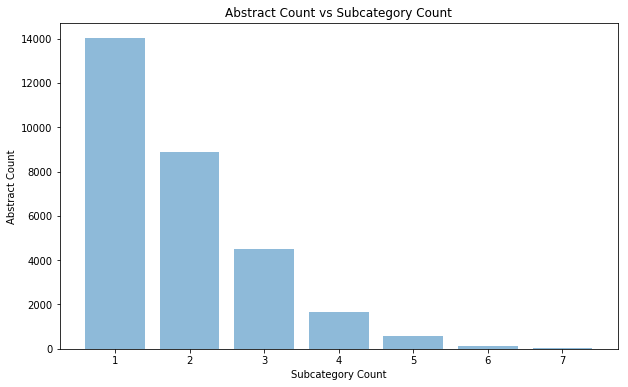

In [11]:
def output_subcategory_stats(df):
    # compute stats
    max_category_count = max(len(x) for x in df['subcategories'])
    category_count_to_abstract_count = [0] * max_category_count
    for categories in df['subcategories']:
        category_count_to_abstract_count[len(categories) - 1] += 1

    # generate bar plot
    category_count_names = [str(x + 1) for x in range(0, max_category_count)]
    y_pos = np.arange(len(category_count_names))
    plt.figure(figsize = (10,6))
    plt.bar(y_pos, category_count_to_abstract_count, align='center', alpha=0.5)
    plt.xticks(y_pos, category_count_names)
    plt.ylabel('Abstract Count')
    plt.xlabel('Subcategory Count')
    plt.title('Abstract Count vs Subcategory Count')

output_subcategory_stats(df)

Here is how many research papers are labeled with exactly one, two or more main categories. We see that majority of papers have between 1 and 3 main categories.

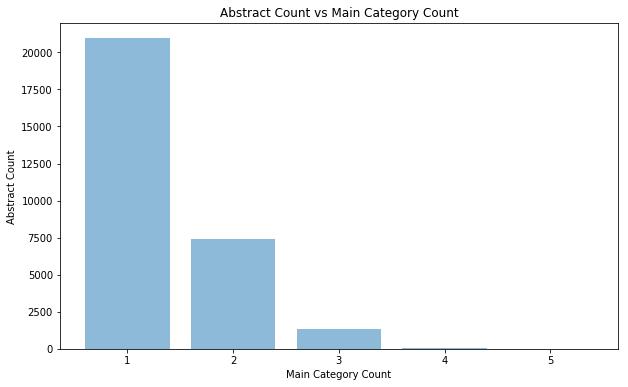

In [12]:
def output_main_category_stats(df):
    # compute stats
    max_category_count = max(len(x) for x in df['main_categories'])
    category_count_to_abstract_count = [0] * max_category_count
    for categories in df['main_categories']:
        category_count_to_abstract_count[len(categories) - 1] += 1
    # generate bar plot
    category_count_names = [str(x + 1) for x in range(0, max_category_count)]
    y_pos = np.arange(len(category_count_names))
    plt.figure(figsize = (10,6))
    plt.bar(y_pos, category_count_to_abstract_count, align='center', alpha=0.5)
    plt.xticks(y_pos, category_count_names)
    plt.ylabel('Abstract Count')
    plt.xlabel('Main Category Count')
    plt.title('Abstract Count vs Main Category Count')

output_main_category_stats(df)

Next, let's look at all possible combinations of main categories on training data set. We see that most papers come from physics, math and computer science. Most common combinations of two labels are: math+physics, cs+math, cs+stat.

We also note that the set is fairly unbalanced. We could try to artificially balance the data set later, but for now we can try to get high prediction accuracy over the majority classes, while maintaining reasonable accuracy for the minority classes.

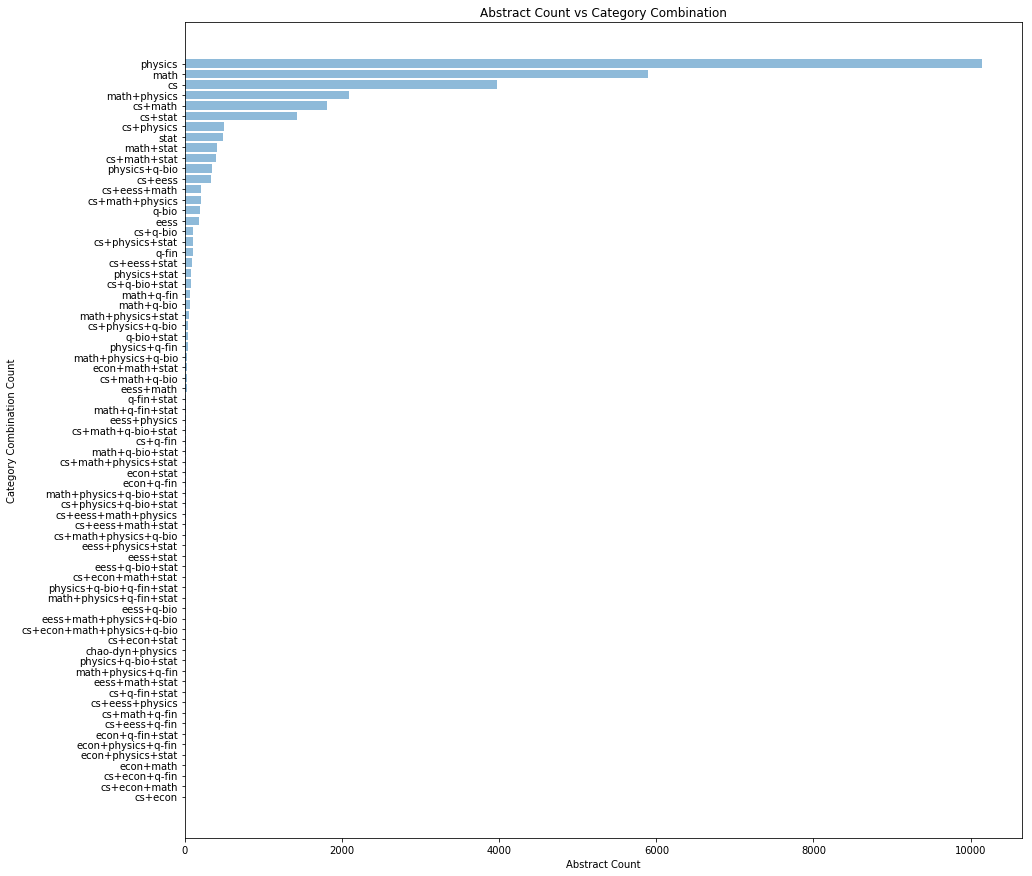

In [15]:
import operator

def output_main_category_tuple_stats(df):
    # compute stats
    category_tuple_to_count = {}
    for categories in df['main_categories']:
        category_tuple = "+".join(sorted(categories))
        if not category_tuple in category_tuple_to_count:
            category_tuple_to_count[category_tuple] = 0
        category_tuple_to_count[category_tuple] += 1

    # generate bar plot
    sorted_items = sorted(category_tuple_to_count.items(), key=operator.itemgetter(1))
    category_tuples = []
    counts = []
    for category_tuple, count in sorted_items:
        category_tuples.append(category_tuple)
        counts.append(count)

    y_pos = np.arange(len(category_tuples))
    plt.figure(figsize=(15, 15))
    plt.barh(y_pos, counts, align='center', alpha=0.5)
    plt.yticks(y_pos, category_tuples)
    plt.xlabel('Abstract Count')
    plt.ylabel('Category Combination Count')
    plt.title('Abstract Count vs Category Combination')
    
output_main_category_tuple_stats(df)

Let's take a peak at the most common words in a data set. For that purpose, we will use the wordcloud.

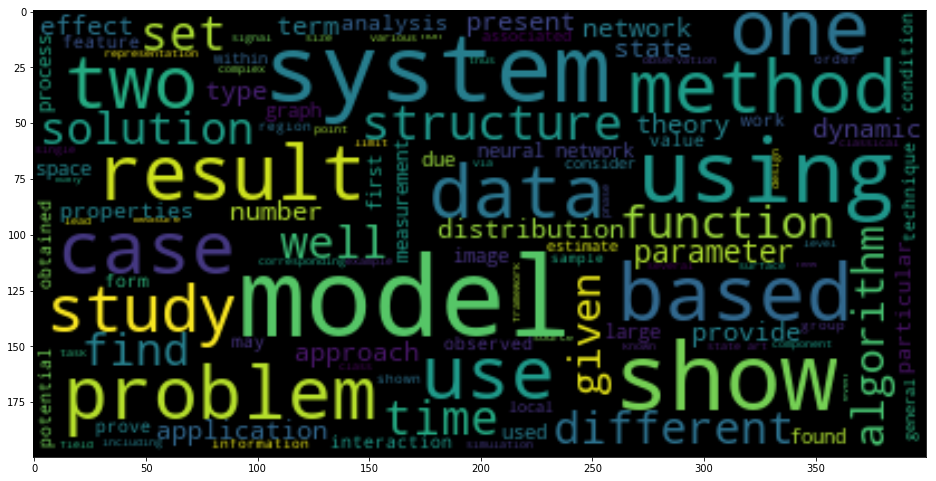

In [61]:
from wordcloud import WordCloud

totalText = ''
for x in df.abstract:
    totalText = totalText + ' ' + x


wc = WordCloud(background_color='black', max_font_size=50).generate(totalText)
plt.figure(figsize=(16, 12))
plt.imshow(wc, interpolation="bilinear")    # mapping integer feature names to original token string

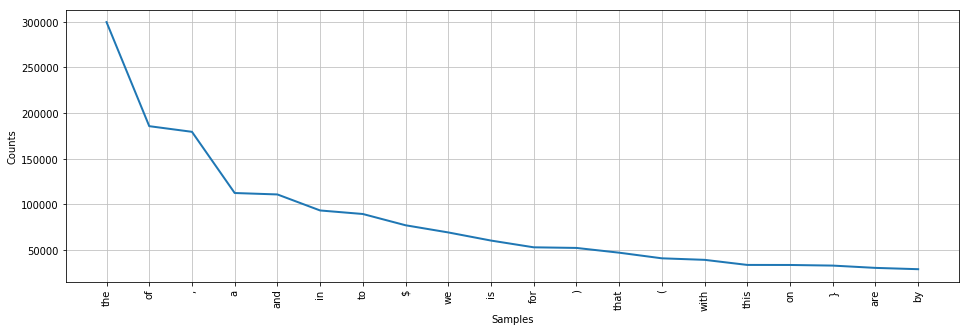

In [66]:
#frequency of the words
import nltk
from nltk.tokenize import ToktokTokenizer

x = nltk.FreqDist(ToktokTokenizer().tokenize(totalText))
plt.figure(figsize=(16,5))
x.plot(20)

We are also going to randomize the data set, so that even when taking smaller samples of data set for testing, we get relativelly equal representation of all categories.

In [16]:
def randomize_dataset(df):
    df_new = df.sample(frac=1).reset_index(drop=True)
    return df_new

df = randomize_dataset(df)

NOTE: Due to code complexity, from here onward you can only see the snippets of the code. Full version of the code can be found [here](https://github.com/ivanamilovanovic/datascience/tree/master/abstracts)

## 3. Text preprocessing

In [ ]:
print("Reading train set: %s" % args.train_data, flush=True)
df_train = pd.read_csv(args.train_data, nrows=args.max_rows)
df_train.head()

print("Reading test set: %s" % args.test_data, flush=True)
df_test = pd.read_csv(args.test_data, nrows=args.max_rows)
df_test.head()

We are going to normalize training and test abstracts. We will remove special characters and stop words and do the lemmatization. After scraping, text is allready in lowercase and we're leaving in numbers for now, as we have some math-heavy categories.

In [14]:
def normalize_abstracts(df):
    stopWordList = stopwords.words('english')
    lemma = WordNetLemmatizer()
    token = ToktokTokenizer()

    def remove_special_chars(text):
        str_chars = '`-=~@#$%^&*()_+[!{;”:\’><.,/?”}]'
        for w in text:
            if w in str_chars:
                text = text.replace(w,'')
        return text

    def lemitize_words(text):
        words = token.tokenize(text)
        listLemma =[]
        for w in words:
            x = lemma.lemmatize(w,'v')
            listLemma.append(x)
        text = " ".join(listLemma)
        return text

    def stop_words_remove(text):
        wordList = [x.strip() for x in token.tokenize(text)]
        removedList = [x for x in wordList if not x in stopWordList]
        text =" ".join(removedList)
        return text

    def preprocessing_text(text):
        text = remove_special_chars(text)
        text = lemitize_words(text)
        text = stop_words_remove(text)
        return text

    df['abstract'] = df['abstract'].map(lambda x: preprocessing_text(x))
    
normalize_abstracts(df_train)
normalize_abstracts(df_test)

Now we need to represent our categorical values as binary vectors, and for that we are using one hot encoding. This is a requirement for later using Binary Relevance as our baseline approach.

In [ ]:
# main categories is list serialized as string, convert it back
df_train['main_categories'] = df_train['main_categories'].apply(eval)
df_test['main_categories'] = df_test['main_categories'].apply(eval)

In [ ]:
#apply one-hot encoding for Binary Relevance
def one_hot_encoder(tags):
    vec = [0] * len(category_to_id)
    for tag in tags:
        if tag in category_to_id:
            vec[category_to_id[tag]]=1
        else:
            print("WARNING: ignoring tag %s", tag)
    return vec

#Map main categories to integers
unique_categories = set()
for n in df_train.main_categories:
    unique_categories.update(n)
category_to_id = dict([(j,i) for i, j in enumerate(sorted(unique_categories))])
id_to_category = [0] * len(category_to_id)
for cat, id in category_to_id.items():
    id_to_category[id] = cat

print("Generate one hot outputs in training set", flush=True)
y_df_train = df_train['main_categories'].apply(one_hot_encoder)
y_df_train = pd.DataFrame(y_df_train.values.tolist(), columns=range(0, len(category_to_id)))

print("Generate one hot outputs in test set", flush=True)
y_df_test = df_test['main_categories'].apply(one_hot_encoder)
y_df_test = pd.DataFrame(y_df_test.values.tolist(), columns=range(0, len(category_to_id)))


## 4. Text classification

Next step is to build a classifier. In the example shown below, we are using both titles and abstracts as inputs. We experimented with different scenarios: using only title, only abstract, or both.

In [13]:
x1_train = df_train['title'].values
x2_train = df_train['abstract'].values
y_train = y_df_train.values
x_train = np.vstack((x1_train, x2_train))
x_train = x_train.T

x1_test = df_test['title'].values
x2_test = df_test['abstract'].values
y_test = y_df_test.values
x_test = np.vstack((x1_test, x2_test))
x_test = x_test.T

print("%d documents in train set" %len(x_train), flush=True)
print("%d documents in test set" % len(x_test), flush=True)

### 4.1. Feature extraction

As a way to summarize titles and abstracts, and to convert them into numerical values, we are using Tf-idf vectorization. Words with high Tf-idf score are words that appear frequently in the document and provide the most information about that specific document. In the code below, we left the possibility of working with different n-grams. We tested different combinations of unigrams, bigrams and trigrams.

In [ ]:
print("Extracting features", flush=True)

from sklearn.feature_extraction.text import TfidfVectorizer

feature_names = []
train_feature_groups = []
test_feature_groups = []

# title features
vec_title = None
if args.title_ngrams > 0:
    vec_title = TfidfVectorizer(sublinear_tf=True, stop_words='english', ngram_range=(1,args.title_ngrams), min_df=args.title_min_df)
    train_feature_groups.append(vec_title.fit_transform(x_train[:,0]))
    feature_names += get_feature_names("tit-", vec_title)
    test_feature_groups.append(vec_title.transform(x_test[:,0]))

# abstract features
vec_abstract = None
if args.abstract_ngrams > 0:
    vec_abstract = TfidfVectorizer(sublinear_tf=True, stop_words='english', ngram_range=(1,args.abstract_ngrams), min_df=args.abstract_min_df)
    train_feature_groups.append(vec_abstract.fit_transform(x_train[:,1]))
    feature_names += get_feature_names("abs-", vec_abstract)
    test_feature_groups.append(vec_abstract.transform(x_test[:,1]))

assert len(train_feature_groups) > 0
assert len(test_feature_groups) > 0

x_train = scipy.sparse.hstack(tuple(train_feature_groups))
x_test = scipy.sparse.hstack(tuple(test_feature_groups))

print("Total feature count: %d" % len(feature_names), flush=True)


### 4.2. Feature selection

We perform Chi-Square feature selection to identify features in our data that contribute most to the prediction variable.

In [ ]:
def fit_chi_square_feature_selection(x_train, y_train, feature_names, feature_count):
    from sklearn.feature_selection import SelectKBest, chi2
    ch2 = SelectKBest(chi2, k=feature_count)
    x_train = ch2.fit(x_train, y_train)
    feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]
    feature_names = np.asarray(feature_names)
    return ch2, feature_names


# selecting the best k features from the data set
feature_count = int(feature_ratio * len(feature_names))
print("Extracting %.1f%% best features by a chi-squared test" % (feature_ratio * 100))
ch2, feature_names_sel = fit_chi_square_feature_selection(x_train, y_train, feature_names, feature_count)
x_train_sel = ch2.transform(x_train)
x_test_sel = ch2.transform(x_test)

We also experiment with different machine learning models:

 1. Binary Relevance with Naive Beyes (BR-NB)
 2. Binary Relevance with Logistic Regression (BR-LR)
 3. Classifier Chains with Logistic Regression (CC-LR)
 4. Label Powerset with Logistic Regression (LP-LR). 

In [ ]:
classifier_details = "NA"
if args.binary_relevance_naive_bayes:
    print("Train binary relevance naive bayes tagger")
    classifier = BinaryRelevance(GaussianNB())
    classifier.fit(x_train_sel, y_train)

elif args.binary_relevance_logistic_regression:
    print("Train binary relevance logistic regression tagger")
    if len(args.classifier_C) > 1:
        parameters = [
            {
                'classifier': [LogisticRegression(solver='liblinear')],
                'classifier__C': args.classifier_C,
            }
        ]
        # iid = True : use average across folds as selection criteria
        # refit = True : fit model on all data after getting best parameters with CV
        gridSearch = GridSearchCV(BinaryRelevance(), parameters, scoring='accuracy', iid=True, refit=gridsearch_refit, n_jobs=args.n_jobs, cv = gridsearch_cv)
        gridSearch.fit(x_gridsearch, y_gridsearch)
        classifier_details = "best_params = " + str(gridSearch.best_params_)
        classifier = gridSearch.best_estimator_
    else:
        classifier = BinaryRelevance(LogisticRegression(solver='liblinear', C = args.classifier_C[0]))
        classifier.fit(x_train_sel, y_train)

elif args.classifier_chain_logistic_regression:
    print("Train classifier chain logistic regression tagger")
    if len(args.classifier_C) > 1:
        parameters = [
            {
                'classifier': [LogisticRegression(solver='liblinear')],
                'classifier__C': args.classifier_C,
            }
        ]
        # iid = True : use average across folds as selection criteria
        # refit = True : fit model on all data after getting best parameters with CV
        gridSearch = GridSearchCV(ClassifierChain(), parameters, scoring='accuracy', iid=True, refit=gridsearch_refit, n_jobs=args.n_jobs, cv = gridsearch_cv)
        gridSearch.fit(x_gridsearch, y_gridsearch)
        classifier_details = "best_params = " + str(gridSearch.best_params_)
        classifier = gridSearch.best_estimator_
    else:
        classifier = ClassifierChain(LogisticRegression(solver='liblinear', C = args.classifier_C[0]))
        classifier.fit(x_train_sel, y_train)

elif args.label_powerset_logistic_regression:
    print("Train label powerset logistic regression tagger")
    if len(args.classifier_C) > 1:
        parameters = [
            {
                'classifier': [LogisticRegression(solver='liblinear')],
                'classifier__C': args.classifier_C,
            }
        ]
        # iid = True : use average across folds as selection criteria
        # refit = True : fit model on all data after getting best parameters with CV
        gridSearch = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy', iid=True, refit=gridsearch_refit, n_jobs=args.n_jobs, cv = gridsearch_cv)
        gridSearch.fit(x_gridsearch, y_gridsearch)
        classifier_details = "best_params = " + str(gridSearch.best_params_)
        classifier = gridSearch.best_estimator_
    else:
        classifier = LabelPowerset(LogisticRegression(solver='liblinear', C = args.classifier_C[0]))
        classifier.fit(x_train_sel, y_train)

else:
    print("ERROR: specify classification model")
    exit()


Lastly, we evaluate test set with the model and calculate accuracy.

In [ ]:
# evaluate test set with the model
predictions = classifier.predict(x_test_sel.astype(float))
predictions = predictions.todense()
# score evaluation results
accuracy_score = metrics.accuracy_score(y_test, predictions)
classification_report = metrics.classification_report(y_test, predictions, target_names=id_to_category)

## 5. Results

We started with a set of papers scraped over the period of one month, which had about 15000 instances. We randomly split the dataset into a training data (75%) and a test data (25%). After we did the inital experiment, using Binary Relevance with regularized Logistic Regression, the results showed high accuracy on test set, but overfitting on the training set.

Our first thought was that perhaps papers uploaded to arXiv.org during a short time period were somehow similar to each other (e.g. addressing similar topics). To test this hypothesis, we tried to scrape training and test sets separately, from a different time periods (about a year apart). This didn't solve the overfitting issue, but did show lower accuracy on test set, confirming the hypothesis that training and test set from different time periods were less similar.

To further address training set overfitting, we tried several other things:

1. feature selection (using Chi-square method)
2. increasing cut-off for infrequent words (using min_df parameter in TfidfVectorizer)
3. scraping data from longer time period (jan-june 2018) and increasing the training data set

Using a larger dataset scraped over a longer time period solved the problem of overfitting the training set. This set was selected for further analysis. In this set, we have 77349 documents in the training set and 19598 documents in the test set.

We experimented with different inputs (title/abstract) and different tokenisations (unigrams, bigrams and trigrams). We hypothesized that title and abstract used together should increase model accuracy and that higher order n-grams will be more informative.
The model used as baseline was the Binary Relevance with regularized logistic regression and with all features included. We used cross-validated grid parameter search (GridSearchCV) for parameter tuning.

The experiments were:
1. using title unigrams ($t_{1}$)
2. using title unigrams and bigrams ($t_{1,2}$)
3. using title unigrams, bigrams and trigrams ($t_{1,2,3}$)
4. using abstract unigrams ($a_{1}$)
5. using abstract unigrams and bigrams ($a_{1,2}$)
6. using abstract unigrams, bigrams and trigrams ($a_{1,2,3}$)
7. using the best combination of title + abstract, based on the results of previous analysis ($t$ + $a$)

| Experiment | $t_{1}$ | $t_{1,2}$ | $t_{1,2,3}$ | $a_{1}$ | $a_{1,2}$ | $a_{1,2,3}$ | $t_{1,2}$ + $a_{1,2,3}$ |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Accuracy | 0.725 | 0.734 | 0.733 | 0.784 | 0.796 | 0.797 | 0.792 |

We got the best accuracy on test set when using abstracts with unigrams, bigrams and trigrams ($a_{1,2,3}$), 0.797.

Accuracy measure on the training set was 0.964.

Classification report for test set showed higher precision for more dominant categories in the dataset (cs, math and physics).

Classification report:
              
              precision    recall  f1-score   support
          cs       0.90      0.88      0.89      5134
        eess       0.65      0.15      0.25       413
        math       0.91      0.87      0.89      6255
     physics       0.97      0.93      0.95      9568
       q-bio       0.75      0.36      0.49       350
       q-fin       0.83      0.48      0.61       131
        stat       0.81      0.55      0.65      1837
        
    micro avg       0.92      0.85      0.89     23688
    macro avg       0.83      0.60      0.68     23688
    weighted avg       0.91      0.85      0.88     23688
    samples avg       0.92      0.90      0.90     23688

Interestingly, adding titles to abstracts resulted in lower accuracy on the test set (accuracy measure = 0.793), probably due to the training set overfitting (accuracy measure = 0.992). The input combination for this model was titles with unigrams and bigrams ($t_{1,2}$) and abstracts with unigrams + bigrams + trigrams ($a_{1,2,3}$).

#### Feature selection results

We used feature selection to select a compact feature subset with maximal discriminative capability. Input to the model where abstracts with unigrams + bigrams + trigrams ($a_{1,2,3}$).
We trained the Binary Relevance with Logistic Regression model iteratively, by including 10% more features in each iteration, given by chi-square feature selection.<br>
As shown in the table below, using 30% of the most relevant features gives us the best prediction accuracy.<br>

| % features | 10% | 20% | 30% | 40% | 50% | 60% | 70% | 80% | 90% | 100% |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Accuracy | 0.792 | 0.795 | __0.798__ | 0.795 | 0.796 | 0.797 | 0.797 | 0.797 | 0.797 | 0.797 |

#### Comparison of different classifiers

We experimented with different machine learning models. The input to all models were abstracts unigrams, bigrams and trigrams ($a_{1,2,3}$), and only 30% top features where fed to the model.

Here we compare Binary Relevance with Naive Beyes (__BR-NB__), Binary Relevance with Logistic Regression (__BR-LR__), Classifier Chains with Logistic Regression (__CC-LR__) and Label Powerset with Logistic Regression (__LP-LR__). 

| Training model | BR-NB | BR-LR | CC-LR | LP-LR |
| --- | --- | --- | --- | --- |
| Accuracy | 0.638 | 0.798 | 0.802 | __0.812__ |

Label Powerset is the best performing model, with accuracy of 0.812, followed by Classifier Chains.

classification report:

              precision    recall  f1-score   support
          cs       0.90      0.88      0.89      5134
        eess       0.76      0.13      0.22       413
        math       0.92      0.86      0.89      6255
     physics       0.96      0.93      0.95      9568
       q-bio       0.84      0.28      0.42       350
       q-fin       0.87      0.40      0.55       131
        stat       0.83      0.54      0.65      1837
        
    micro avg      0.93      0.85      0.88     23688
    macro avg      0.87      0.58      0.65     23688
    weighted avg   0.92      0.85      0.87     23688
    samples avg    0.94      0.89      0.90     23688


From classification report, we see that the classifier has low recall on underrepresented categories. This is somewhat expected due to a high imbalance between categories. In future, we could try a few dataset balancing techniques, like over-sampling under-represented categories or weighting classes differently, and check how that affects accuracy.